# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 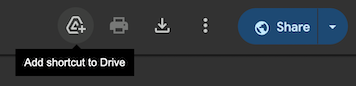

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Скачаем данные для обучения и тестирования:

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in dataset['FullDescription']:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)

In [ ]:
MAX_VOCAB_SIZE = 20000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 20000, 20000, 141, 18, 20000, 20000, 3605, 20000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 20000, 14, 20000, 20000, 4674, 393, 871, 20000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 20000, 20000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
part_tokens, test_tokens, part_target, test_target = train_test_split(
    tokens, target, random_state=300
)


train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    part_tokens, part_target, random_state=300
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))
test_target_std = scaler.transform(np.array(test_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
test_data = SalaryPredictionDataset(test_tokens, test_target_std)

len(train_data), len(valid_data), len(test_data)

(112500, 37500, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1103, 0.2308, 0.1744, ...


\Сформируйте даталоадеры для обучения и валидации и тестирования.

In [ ]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        # x.shape = (batch_size, max_pad_len)

        # Получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        predictions = self.classifier(h_state)
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(0)
        loss = criterion(predictions, labels.float())
        mse_val = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += mse_val.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(0)
            # посчитаем метрики
            loss = criterion(predictions, labels.float())
            mse_val = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += mse_val.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

В модели2 изменили шаг обучения. Теперь lr = 0.01 вместо 0.005. Также в словаре 20000 слов, а rnn_num_units=256

In [ ]:
model2 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=256,
    output_dim=1,
).to(device)


# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
history = []

# Посмотрите на получившуюся модель
model2

SimpleRNNRegressor(
  (emb): Embedding(20002, 100, padding_idx=20001)
  (rnn): LSTM(100, 256, batch_first=True)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)

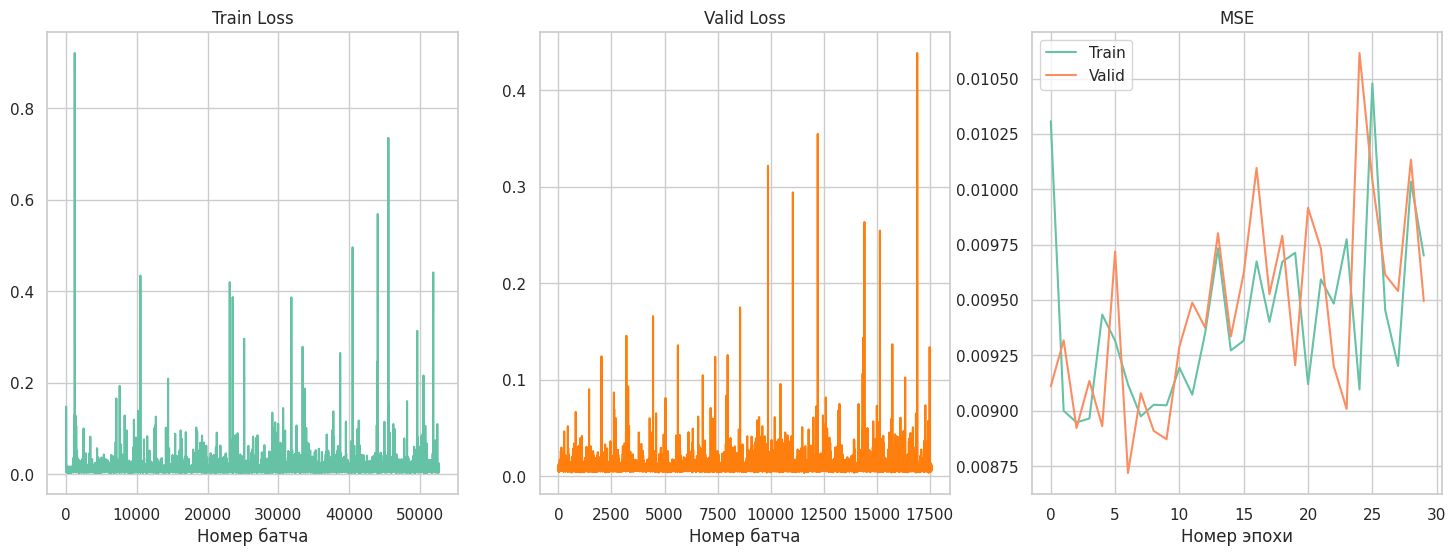

Номер эпохи: 30 | Время обучения эпохи: 1m 57s


In [ ]:
training_loop(model2, 30)

In [ ]:
data_batch, real_wages_batch = next(iter(test_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    preds2 = model2(data_batch.to(device))

In [ ]:
# Выведем предсказания для 5 случайных примеров из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
preds_okay2 = scaler.inverse_transform(preds2[0].cpu().numpy())
real_wages_okay = scaler.inverse_transform(real_wages_batch.numpy())
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"Predicted wage: {preds_okay2[idx][0]}")
    print(f"True wage: {real_wages_okay[idx].item()}")
    print()

Text:
Our client digital marketing advertising agency Greater Manchester area looking experienced individual PPC manage department This agency successfully specialised number online channels significant client years They doubled headcount last year ambitious plans next – 24 months Online marketing digital marketing specialism Natural demand diverse range online digital national international direct response clients means launching search PPC division require experienced search manager PPC Manager launch department grow advertising agency 's offering The company give full support investment successful candidate plan grow offering significantly coming months years This great way develop online marketing digital advertising career Their initial large spending client operate PPC campaigns across multiple English non English speaking territories Experience managing type similar type campaign essential Spend tens thousands per month per campaign Do fit following criteria   Have working PPC s

In [ ]:
mse_model2 = mse(preds2[0].cpu(), real_wages_batch)
mse_model2.item()

0.007673224434256554

In [ ]:
mse_model2_original = mse(torch.tensor(preds_okay2), torch.tensor(real_wages_okay))
mse_model2_original.item()

291774336.0

В модели 3 rnn_num_units = 128. Также в словаре 20000 слов, как в 2 модели. А шаг lr=0.005, как в первой.

In [ ]:
model3 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=128,
    output_dim=1,
).to(device)


# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.005)
history = []

# Посмотрите на получившуюся модель
model3

SimpleRNNRegressor(
  (emb): Embedding(20002, 100, padding_idx=20001)
  (rnn): LSTM(100, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)

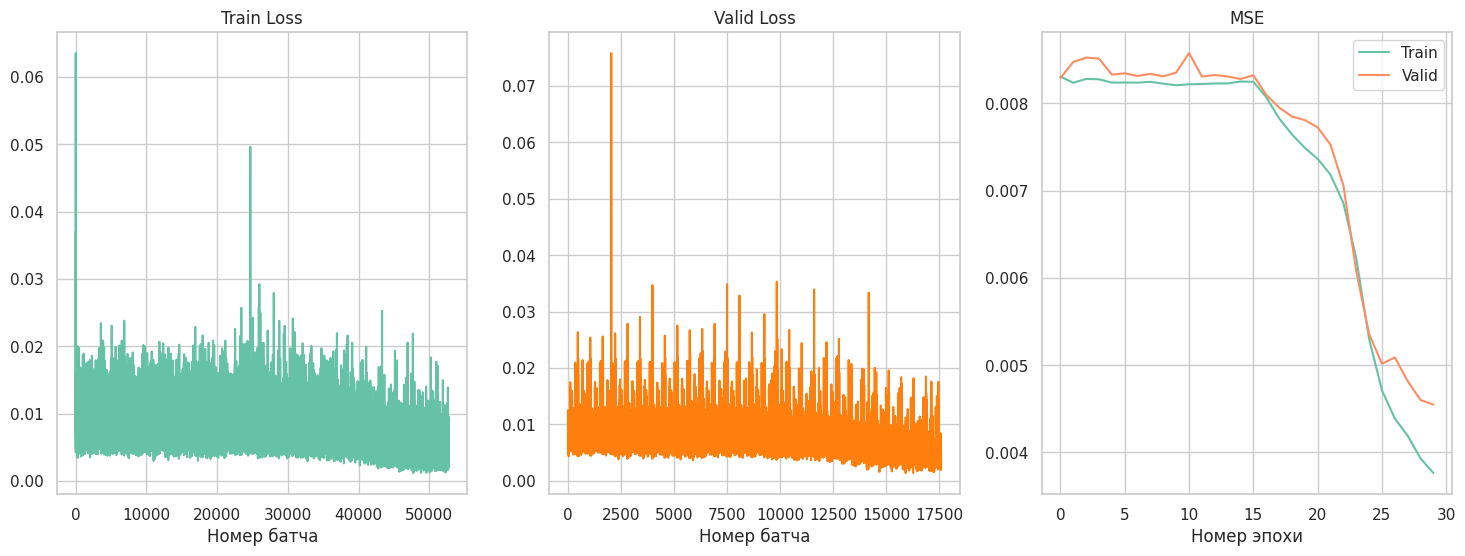

Номер эпохи: 30 | Время обучения эпохи: 0m 48s


In [ ]:
training_loop(model3, 30)

In [ ]:
with torch.no_grad():
    preds3 = model3(data_batch.to(device))

In [ ]:
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
preds_okay3 = scaler.inverse_transform(preds3[0].cpu().numpy())
real_wages_okay = scaler.inverse_transform(real_wages_batch.numpy())
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"Predicted wage: {preds_okay3[idx][0]}")
    print(f"True wage: {real_wages_okay[idx].item()}")
    print()

Text:
Due fundamental reforms currently undertaken within NHS creating new CCG 's legally closing historic PCT 's Temporary Opportunity band 5 candidate arisen within Newcastle area Qualified Management Accountant This fantastic opportunity join large public sector organisation exciting challenging times The role Will involve management accountant duties within Analysis information Ledger preparations reports turn feeding back levels senior management To considered role Knowledge experience Oracle system essential teamed previous public sector experience The successful candidate MUST proficient user excel To considered role please forward CV This job originally posted www.totaljobs.com/JobSeeking/ManagementAccountant_job
Predicted wage: 45969.39453125
True wage: 35520.0

Text:
Senior Business Travel Consultant   Liverpool L New team Business Travel Consultants   Liverpool city centre   fantastic location Are experienced business travel consultant wants work expanding business travel co

In [ ]:
mse_model3 = mse(preds3[0].cpu(), real_wages_batch)
mse_model3.item()

0.0033566923812031746

In [ ]:
mse_model3_original = mse(torch.tensor(preds_okay3), torch.tensor(real_wages_okay))
mse_model3_original.item()

127638232.0

**Итог:**
У нас было 3 модели:
1. шаг обучения = 0.005, словарь - 25000 слов, rnn_num_units = 64
2. шаг обучения = 0.01, словарь - 20000 слов, rnn_num_units = 256
3. шаг обучения = 0.005, словарь - 20000 слов, rnn_num_units = 128

Время обучения 1 эпохи : 21 сек - 1 мин 57 сек - 48 сек

mse в приведенных зп: 0.00405 - 0.00767 - 0.00335


**Вывод:**
1. Лучшие результаты mse дала 3 модель, худшие - 2 модель.

2. В 1 и 3 моделях mse было примерно постоянным, затем начало существенно падать на 14-15 итерациях, в 2 модели существенного падения не было.

3. На графиках 1 и 3 модели после 20 эпохи mse тренировочной выборки ниже, чем у валидационной (что соответствует здравому смыслу, поскольку может быть переобучение).

4. Сравним времена одной эпохи, количество rnn_num_units. Чем меньше rnn_num_units, тем меньше время обучения одной эпохи, причем существенно. На наших данных возрастание rnn_num_units в 2 раза приводит к возрастанию времени одной эпохи более, чем в 2 раза.

5. Модель в 2 случае обучилась значительно хуже. Это наглядно продемонстрировано на графиках (mse колеблется вокруг одного значения, примерно не падая, в то время как в 1 и 3 моделях видно уменьшение mse с эпохами). Можно даже сказать, что она практически не обучилась. Значение mse на 30 эпохе относительно велико и близко к тому, что было на 1 эпохе. Это связано с тем, что шаг слишком велик, и при обучении мы "пропрыгиваем" нужные параметры модели.

6. Сравнивая времена эпохи для 1 и 3 модели, становится ясно, что изменение количества слов в словаре на 20% несущественно повлияло на изменение времени работы относительно изменения rnn_num_units в 2 раза(оно все равно увеличилось примерно в 2 раза)

*Пояснение:*

Среди наиболее встречаемых слов был обнаружен пробел - это, безусловно, не является словом в привычном смысле слова. Однако в данной задаче показалось разумным его оставить. Дело в том, что частая встречаемость двойных пробелов в описании професии от работодателя может свидетельствовать о несильно проработанном и отформатированном тексте, что, в свою очередь, может быть индикатором не очень серьезного отношения к данному роду деятельности, неквалифицированном отделе кадров в данной компании и тд. Это может напрямую коррелировать с ожидаемой зарплатой от будущего работника. Можно даже выдвинуть гипотезу, что чем больше двойных пробелов в тексте - тем ниже зарплата. Но пока это всего лишь догадки. Для более детального ответа на данный вопрос и проверки гипотезы нужно провести отдельный тщательный анализ. В первом же приближении пробелы были намеренно оставлены.